In [1]:
# %pip install pandas
# %pip install scikit-learn
# %pip install plotly
# %pip install seaborn
# %pip install numpy
# %pip install matplotlib
# %pip install nbformat
# %pip install opencv-python
# %pip install tensorflow
# %pip install wandb
# %pip install imblearn

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import cv2
import os
import plotly.express as px
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE


import wandb
%env "WANDB_NOTEBOOK_NAME" "model_balanced_vgg16.ipynb"

wandb.login()

from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


env: "WANDB_NOTEBOOK_NAME"="model_balanced_vgg16.ipynb"


wandb: Currently logged in as: pedro-mariani (dspro2-group9). Use `wandb login --relogin` to force relogin


In [3]:
label_df = pd.read_csv(
    "../../../data/processed/combined/combined_label.csv", index_col=False
)
data_dir = "../../../data/processed/combined/img/"

label_df.head()

,image_name,expression_label
0,angry_0.jpg,angry
1,angry_1.jpg,angry
2,fear_2.jpg,fear
3,angry_4.jpg,angry
4,angry_5.jpg,angry


In [4]:
def load_data(dir_path, img_size):
    X = []
    y = []

    for index, row in label_df.iterrows():
        image_path = os.path.join(dir_path, row["image_name"])
        img = cv2.imread(image_path)
        img = (
            cv2.resize(img, img_size, interpolation=cv2.INTER_AREA).astype("float32")
            / 255
        )
        X.append(img)
        y.append(row["expression_label"])

    X = np.array(X)
    y = np.array(y)
    return X, y

In [5]:
IMG_SIZE = (96, 96)

X, y = load_data(data_dir, IMG_SIZE)

In [6]:
dummies = pd.get_dummies(label_df["expression_label"])
dummies.head()

,angry,disgust,fear,happy,neutral,sad,surprise
0,True,False,False,False,False,False,False
1,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False


In [7]:
y = dummies.values
y

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

In [8]:
train_ratio = 0.80
test_ratio = 0.10
validation_ratio = 0.10


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=validation_ratio / (train_ratio + test_ratio)
)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(53676, 96, 96, 3)
(6710, 96, 96, 3)
(6710, 96, 96, 3)
(53676, 7)
(6710, 7)
(6710, 7)


# Distribution of classes in each set


In [9]:
class_count_in_train_set = np.sum(y_train, axis=0)

print("Class distribution:")
print(class_count_in_train_set)

Class distribution:
[6909 3606 5001 9481 9833 9985 8861]


In [10]:
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
fig = px.bar(x=labels, y=class_count_in_train_set, color=labels)

fig.update_layout(
    title="Distribution of each label in train set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [11]:
class_count_in_validation_set = np.sum(y_valid, axis=0)

print("Class distribution:")
print(class_count_in_validation_set)

Class distribution:
[ 865  447  579 1197 1246 1287 1089]


In [12]:
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
fig = px.bar(x=labels, y=class_count_in_validation_set, color=labels)

fig.update_layout(
    title="Distribution of each label in validation set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [13]:
class_count_in_test_set = np.sum(y_test, axis=0)

print("Class distribution:")
print(class_count_in_test_set)

Class distribution:
[ 850  489  629 1180 1245 1205 1112]


In [14]:
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
fig = px.bar(x=labels, y=class_count_in_test_set, color=labels)

fig.update_layout(
    title="Distribution of each label in test set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

# SMOTE

In [15]:
# get all dimensions of the resulting X
n_samples, height, width, n_channels = [X_train.shape[index] for index in range(4)]

# reshape X because SMOTE accepts only (n_samples, n_channels*height*weight)-type data
X_train_reshaped = X_train.reshape(n_samples, n_channels * height * width)

In [16]:
smote = SMOTE(random_state=62)

# perform re-sampling on modified X given y
X_train_smote, y_train_smote = smote.fit_resample(X_train_reshaped, y_train)

Exception in thread Thread-11 (_readerthread):
Traceback (most recent call last):
  File "C:\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\pedro\Documents\Studium\Workspaces\Python\DSPRO2\Emotion_Recognition\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Python311\Lib\subprocess.py", line 1568, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "C:\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>
c:\Users\pedro\Documents\Studium\Workspaces\Python\DSPRO2\Emotion_Recognition\.venv\Lib\site-packages\job

In [17]:
class_count_in_train_smote_set = np.sum(y_train_smote, axis=0)

labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
fig = px.bar(x=labels, y=class_count_in_train_smote_set, color=labels)

fig.update_layout(
    title="Distribution of each label in train set after SMOTE",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

# Data augmentation to balance the dataset


In [18]:
# # Assume x_train and y_train are your original data
# # Create an ImageDataGenerator with desired augmentations
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     brightness_range=(0.8, 1.2),
#     zoom_range=0.1,
# )

# # Generate augmented images for the minority class
# angry_indices = np.where(y_train[:, 0] == 1)[0]
# disgust_indices = np.where(y_train[:, 1] == 1)[0]
# fear_indices = np.where(y_train[:, 2] == 1)[0]
# augmented_angry_images = datagen.flow(
#     X_train[angry_indices], y_train[angry_indices], batch_size=len(angry_indices) // 3
# )
# augmented_disgust_images = datagen.flow(
#     X_train[disgust_indices], y_train[disgust_indices], batch_size=len(disgust_indices)
# )
# augmented_fear_images = datagen.flow(
#     X_train[fear_indices], y_train[fear_indices], batch_size=len(fear_indices)
# )

# # Combine augmented minority class images with original data
# x_train_balanced = np.concatenate(
#     [
#         X_train,
#         augmented_angry_images[0][0],
#         augmented_disgust_images[0][0],
#         augmented_fear_images[0][0],
#     ]
# )
# y_train_balanced = np.concatenate(
#     [
#         y_train,
#         augmented_angry_images[0][1],
#         augmented_disgust_images[0][1],
#         augmented_fear_images[0][1],
#     ]
# )

# class_count_in_balanced_train_set = np.sum(y_train_balanced, axis=0)

# labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
# fig = px.bar(x=labels, y=class_count_in_balanced_train_set, color=labels)

# fig.update_layout(
#     title="Distribution of each label in balanced train set",
#     xaxis_title="Expressions",
#     yaxis_title="Count",
#     height=600,
#     width=800,
# )

# fig.update_traces(texttemplate="%{y}", textposition="inside")

# fig.show()


# Model training


In [19]:
X_train_smote = X_train_smote.reshape(len(X_train_smote), 96, 96, 3)

In [20]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False

In [21]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(7, activation="softmax"))

In [23]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Emotion Recognition",
    name="vgg16_size96_smote_epoch10_40_batch128",
    # track hyperparameters and run metadata with wandb.config
    config={
        "optimizer": "Adam(learning_rate=3e-4)",
        "loss": "categorical_crossentropy",
        "metric": ["categorical_accuracy"],
        "epoch_frozen": 10,
        "epoch_unfrozen": 40,
        "batch_size": 128,
        "architecture": "vgg16",
    },
)

config = wandb.config


In [24]:
model.compile(
    loss=config["loss"],
    optimizer=Adam(learning_rate=3e-4),
    metrics=config["metric"],
)

history = model.fit(
    X_train_smote,
    y_train_smote,
    validation_data=(X_valid, y_valid),
    epochs=config["epoch_frozen"],
    batch_size=config["batch_size"],
    callbacks=[WandbMetricsLogger(log_freq=5)],
)

Epoch 1/10


wandb: ERROR Unable to log learning rate.


547/547 ━━━━━━━━━━━━━━━━━━━━ 694s 1s/step - categorical_accuracy: 0.3080 - loss: 1.7693 - val_categorical_accuracy: 0.3507 - val_loss: 1.6402
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 681s 1s/step - categorical_accuracy: 0.3913 - loss: 1.5799 - val_categorical_accuracy: 0.3648 - val_loss: 1.6326
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 679s 1s/step - categorical_accuracy: 0.4216 - loss: 1.5133 - val_categorical_accuracy: 0.3785 - val_loss: 1.5811
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 680s 1s/step - categorical_accuracy: 0.4454 - loss: 1.4651 - val_categorical_accuracy: 0.4092 - val_loss: 1.5416
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 717s 1s/step - categorical_accuracy: 0.4627 - loss: 1.4180 - val_categorical_accuracy: 0.3921 - val_loss: 1.5677
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 679s 1s/step - categorical_accuracy: 0.4814 - loss: 1.3767 - val_categorical_accuracy: 0.4054 - val_loss: 1.5378
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 677s 1s/step - categorical_accuracy: 0.4965 - loss: 1

In [25]:
base_model.Trainable = True

model.compile(
    loss=config["loss"],
    optimizer=Adam(learning_rate=3e-4),
    metrics=config["metric"],
)

history = model.fit(
    X_train_smote,
    y_train_smote,
    validation_data=(X_valid, y_valid),
    epochs=config["epoch_unfrozen"],
    batch_size=config["batch_size"],
    callbacks=[WandbMetricsLogger(log_freq=5)],
)

Epoch 1/40
547/547 ━━━━━━━━━━━━━━━━━━━━ 675s 1s/step - categorical_accuracy: 0.5653 - loss: 1.1769 - val_categorical_accuracy: 0.4311 - val_loss: 1.5140
Epoch 2/40
547/547 ━━━━━━━━━━━━━━━━━━━━ 704s 1s/step - categorical_accuracy: 0.5802 - loss: 1.1410 - val_categorical_accuracy: 0.4235 - val_loss: 1.5249
Epoch 3/40
547/547 ━━━━━━━━━━━━━━━━━━━━ 692s 1s/step - categorical_accuracy: 0.5984 - loss: 1.0975 - val_categorical_accuracy: 0.4188 - val_loss: 1.5464
Epoch 4/40
547/547 ━━━━━━━━━━━━━━━━━━━━ 682s 1s/step - categorical_accuracy: 0.6086 - loss: 1.0712 - val_categorical_accuracy: 0.4332 - val_loss: 1.5374
Epoch 5/40
547/547 ━━━━━━━━━━━━━━━━━━━━ 681s 1s/step - categorical_accuracy: 0.6248 - loss: 1.0316 - val_categorical_accuracy: 0.4279 - val_loss: 1.5578
Epoch 6/40
547/547 ━━━━━━━━━━━━━━━━━━━━ 686s 1s/step - categorical_accuracy: 0.6346 - loss: 1.0130 - val_categorical_accuracy: 0.4316 - val_loss: 1.5630
Epoch 7/40
547/547 ━━━━━━━━━━━━━━━━━━━━ 681s 1s/step - categorical_accuracy: 0.651

In [26]:
wandb.finish()

batch/batch_step,▁▁▁▂▂▂▂▃▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
batch/categorical_accuracy,▁▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇█████
batch/loss,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/categorical_accuracy,▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇██████
epoch/epoch,▁▁▁▂▂▂▂▂▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
epoch/loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▃▅▅▅▆▇▆▆▆▇▆▆▆▇▇▇▇▆▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇▆▆▇▇
epoch/val_loss,▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇████
batch/batch_step,21995
batch/categorical_accuracy,0.87068
batch/loss,0.37245


In [27]:
model.save("../../../model/240603_vgg16_size96_smote_model.keras")

In [28]:
y_pred = model.predict(X_valid)
true_class = tf.argmax(y_valid, 1)
predicted_class = tf.argmax(y_pred, 1)

210/210 ━━━━━━━━━━━━━━━━━━━━ 57s 270ms/step


[Text(0, 0.5, 'angry'),
 Text(0, 1.5, 'disgust'),
 Text(0, 2.5, 'fear'),
 Text(0, 3.5, 'happy'),
 Text(0, 4.5, 'neutral'),
 Text(0, 5.5, 'sad'),
 Text(0, 6.5, 'surprise')]

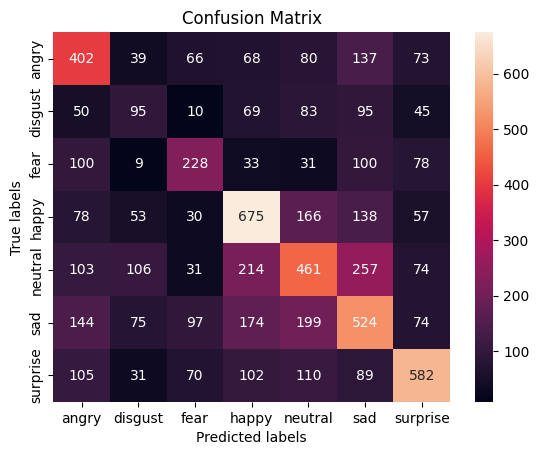

In [29]:
cm = confusion_matrix(true_class, predicted_class)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax)

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(
    ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
)
ax.yaxis.set_ticklabels(
    ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
)